In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo


np.set_printoptions(threshold=np.inf)

In [2]:
system="BlackP"
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/"+system+"/"

In [3]:
nkx=60
nky=60
nkz=60


name_Exciton_energy = str(nkx)+'x'+str(nky)+'x'+str(nkz)+'.log'

result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_new/'+name_Exciton_energy, 'E(1)', "1"],capture_output=True,text=True)
E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]



##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"

ψ = Reading.Read_Density(fname)


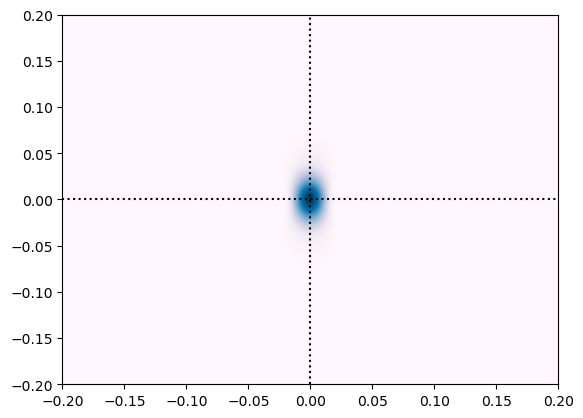

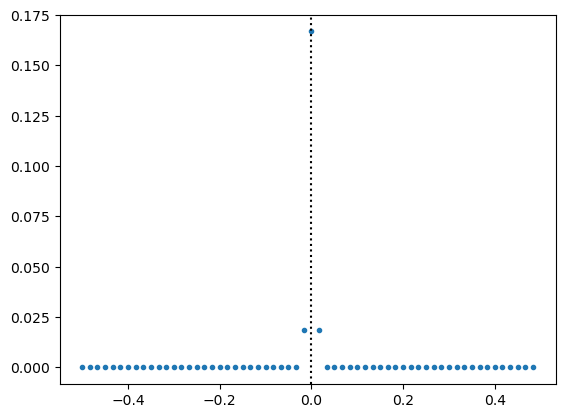

In [4]:
x1 = np.linspace(-0.5,0.5, nkx+1)[0:-1]

fig, ax1 = plt.subplots()

a = ax1.imshow(np.reshape(ψ[0,:], [nkx,nky,nkz])[:,:,int(nkz/2)],\
               extent=[x1.min(),x1.max(),x1.min(),x1.max()],
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

ax1.axvline(x=0,color='black',linestyle=':')
ax1.axhline(y=0,color='black',linestyle=':')

plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

plt.show()

plt.figure()

plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[int(nkx/2),:,int(nkz/2)],'.')
plt.axvline(x=0.0,color='black',linestyle=':')
#plt.xlim(-0.05,0.05)




In [38]:
nkx=60
nky=60
nkz=60

Dp =  np.array([0.034])
Dm = -np.array([0.034])

direccion = 'ky'
zero = '0.00'
        
if direccion =='kx':
    name_Exciton_energy = 'px'+str(Dp[0])+'_py'+zero+'_pz'+zero+'_new.log'
if direccion =='ky':
    name_Exciton_energy = 'px'+zero+'_py'+str(Dp[0])+'_pz'+zero+'_new.log'
    
result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_plus_new/'+name_Exciton_energy, 'E(1)', '1'],capture_output=True,text=True)
E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]

##estos archivos se deben mover a la carpeta de outputs al final del dia
if direccion =='kx':
    fname="./out_Hqpgw_plus_new/"+'px'+str(Dp[0])+'_py'+zero+'_pz'+zero+"_new_exc.h5"
    ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

    fname="./out_Hqpgw_plus_new/"+'px'+str(Dp[0])+'_py'+zero+'_pz'+zero+"_new_exc_dens.h5"

    ψ = Reading.Read_Density(fname)
    
if direccion =='ky':
    fname="./out_Hqpgw_plus_new/"+'px'+zero+'_py'+str(Dp[0])+'_pz'+zero+"_new_exc.h5"
    ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

    fname="./out_Hqpgw_plus_new/"+'px'+zero+'_py'+str(Dp[0])+'_pz'+zero+"_new_exc_dens.h5"

    ψ = Reading.Read_Density(fname)
    
nkx=60
nky=60
nkz=60

In [10]:
np.where(np.reshape(ψ[0,:], [nkx,nky,nkz])==np.max(np.reshape(ψ[0,:], [nkx,nky,nkz])))

(array([24]), array([23]), array([24]))

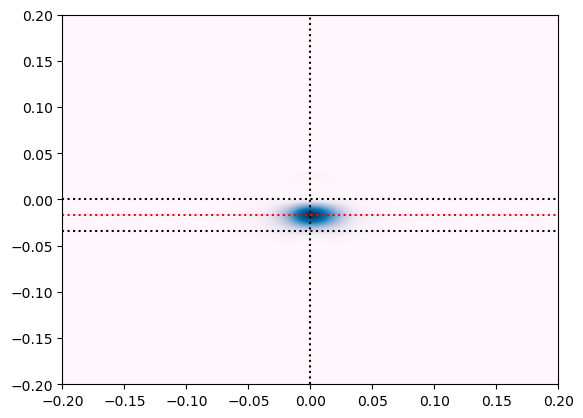

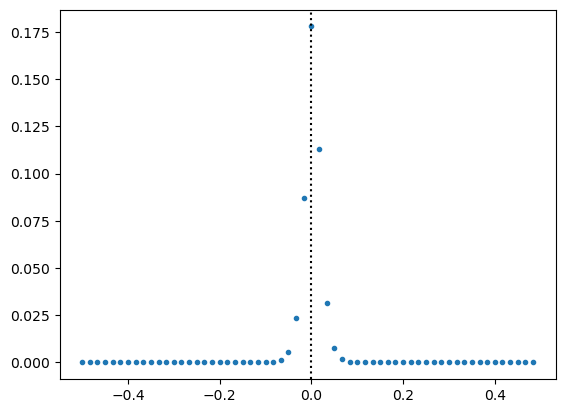

In [37]:
x1 = np.linspace(-0.5,0.5, nkx+1)[0:-1]

fig, ax1 = plt.subplots()

a = ax1.imshow(np.transpose(np.reshape(ψ[0,:], [nkx,nky,nkz])[:,:,int(nkz/2)]),\
               extent=[x1.min(),x1.max(),x1.min(),x1.max()],
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

ax1.axvline(x=0,color='black',linestyle=':')
ax1.axhline(y=0,color='black',linestyle=':')
ax1.axhline(y=-0.034,color='black',linestyle=':')
ax1.axhline(y=-0.01666667,color='red',linestyle=':')
#ax1.axhline(y=-0.016,color='green',linestyle=':')
#ax1.axhline(y=-0.025,color='red',linestyle=':')
#ax1.axhline(y=-0.05,color='red',linestyle=':')


plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

plt.show()

plt.figure()

#plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[int(nkx/2),:,int(nkz/2)],'.')
plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[:,int(nky/2)-1,int(nkz/2)],'.')
plt.axvline(x=0.0,color='black',linestyle=':')
#plt.xlim(-0.05,0.05)




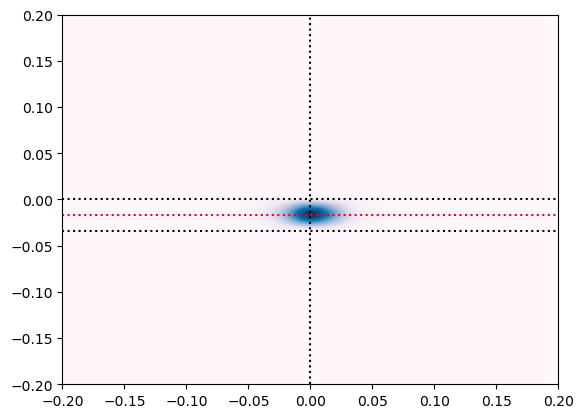

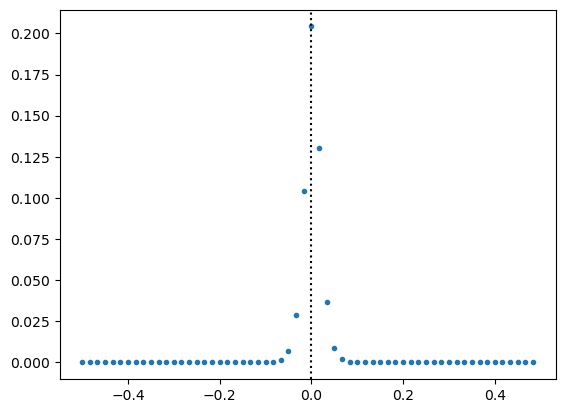

In [39]:
x1 = np.linspace(-0.5,0.5, nkx+1)[0:-1]

fig, ax1 = plt.subplots()

a = ax1.imshow(np.transpose(np.reshape(ψ[0,:], [nkx,nky,nkz])[:,:,int(nkz/2)]),\
               extent=[x1.min(),x1.max(),x1.min(),x1.max()],
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

ax1.axvline(x=0,color='black',linestyle=':')
ax1.axhline(y=0,color='black',linestyle=':')
ax1.axhline(y=-0.034,color='black',linestyle=':')
ax1.axhline(y=-0.01666667,color='red',linestyle=':')
#ax1.axhline(y=-0.016,color='green',linestyle=':')
#ax1.axhline(y=-0.025,color='red',linestyle=':')
#ax1.axhline(y=-0.05,color='red',linestyle=':')


plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

plt.show()

plt.figure()

#plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[int(nkx/2),:,int(nkz/2)],'.')
plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[:,int(nky/2)-1,int(nkz/2)],'.')
plt.axvline(x=0.0,color='black',linestyle=':')
#plt.xlim(-0.05,0.05)



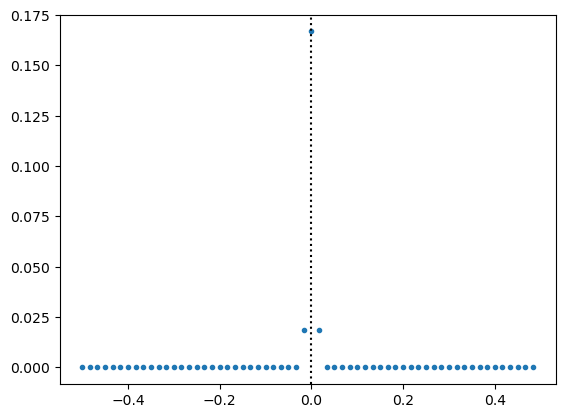

In [59]:
x1 = np.linspace(-0.5,0.5, nkx+1)[0:-1]

plt.plot(x1,np.reshape(ψ[0,:], [nkx,nky,nkz])[int(nkx/2),:,int(nkz/2)],'.')
plt.axvline(x=0.0,color='black',linestyle=':')
#plt.xlim(-0.05,0.05)

In [30]:

x1

array([-0.5       , -0.48333333, -0.46666667, -0.45      , -0.43333333,
       -0.41666667, -0.4       , -0.38333333, -0.36666667, -0.35      ,
       -0.33333333, -0.31666667, -0.3       , -0.28333333, -0.26666667,
       -0.25      , -0.23333333, -0.21666667, -0.2       , -0.18333333,
       -0.16666667, -0.15      , -0.13333333, -0.11666667, -0.1       ,
       -0.08333333, -0.06666667, -0.05      , -0.03333333, -0.01666667,
        0.        ,  0.01666667,  0.03333333,  0.05      ,  0.06666667,
        0.08333333,  0.1       ,  0.11666667,  0.13333333,  0.15      ,
        0.16666667,  0.18333333,  0.2       ,  0.21666667,  0.23333333,
        0.25      ,  0.26666667,  0.28333333,  0.3       ,  0.31666667,
        0.33333333,  0.35      ,  0.36666667,  0.38333333,  0.4       ,
        0.41666667,  0.43333333,  0.45      ,  0.46666667,  0.48333333])

In [ ]:
p_ex = np.array([.0,.0,.0])

nuevok = 170

yp = Photo.Interpolator(nkx,nky,nkz,ψ[0,:],nuevok)

#Ψ_k_p   = Photo.SHIFTING_KplusP(nkx,nky,nkz,ψ[0,:],p_ex)
Ψ_k_p   = Photo.SHIFTING_KplusP(nuevok,nuevok,nuevok,yp,p_ex)
Ec_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,p_ex)
Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,p_ex)
Env_k_p = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,p_ex)